# Predicting Amazon Stock Prices and Check the Accuracy of the Result
- **Goal**: Getting used to using LSTM model(from building train/test set to actually running the model)
- Source: https://data-analysis-expertise.tistory.com/67

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf  #yahoo finance
import tensorflow as tf

## Amazon Stock Price

In [2]:
# Amazon
AMZN = yf.download('AMZN', 
                   start='2013-01-01',
                   end='2019-12-31',
                   progress=True,  # show progress bar
                  )

[*********************100%***********************]  1 of 1 completed


In [3]:
# Adj Close: 수정종가, Open: 시가, High: 최고가, Low: 최저가, Close: 종가, Volume: 거래량
all_data = AMZN[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2012-12-31,250.87,243.75,252.41,242.75,250.87,3419000
2013-01-02,257.31,256.08,258.10,253.26,257.31,3271000
2013-01-03,258.48,257.27,260.88,256.37,258.48,2750900
2013-01-04,259.15,257.58,259.80,256.65,259.15,1874200
2013-01-07,268.46,262.97,269.73,262.67,268.46,4910000
2013-01-08,266.38,267.07,268.98,263.57,266.38,3010700
2013-01-09,266.35,268.17,269.50,265.40,266.35,2265600
2013-01-10,265.34,268.54,268.74,262.30,265.34,2863400
2013-01-11,267.94,265.10,268.43,264.11,267.94,2413300


In [4]:
plt.rc('font', family='Malgun Gothic')

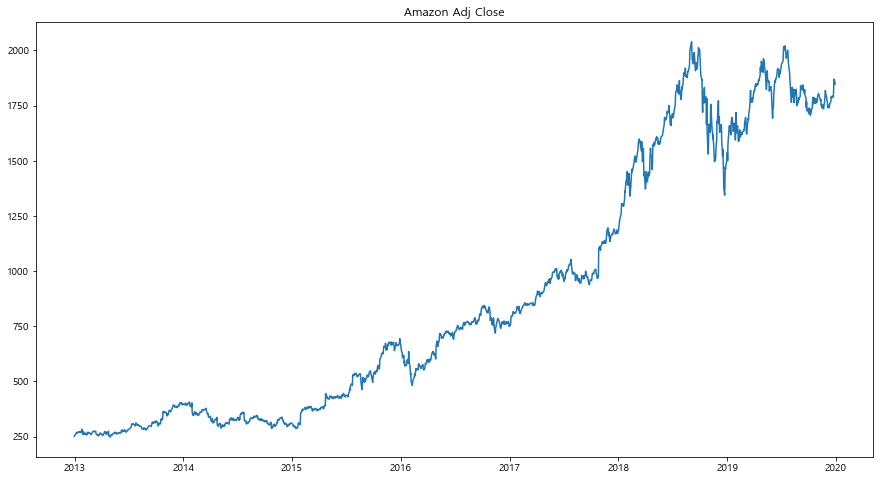

In [5]:
plt.figure(figsize=(15,8))
plt.title("Amazon Adj Close")
plt.plot(all_data['Adj Close'])
plt.show()

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2012-12-31 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1762 non-null   float64
 1   Open       1762 non-null   float64
 2   High       1762 non-null   float64
 3   Low        1762 non-null   float64
 4   Close      1762 non-null   float64
 5   Volume     1762 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.4 KB


In [7]:
# Train set: Data stacked until the end of 2018, Test set: Data of 2019
print("There are " + str(all_data[:'2018'].shape[0]) + " observations in the training data.")
print("There are " + str(all_data['2019':].shape[0]) + " observations in the test data.")

There are 1511 observations in the training data.
There are 251 observations in the test data.


## Train/Test Sets for LSTM
- 3 Dimensions: "samples", "time steps", "features"
- **Samples**: The size of the data that goes in to the model
- **Time steps**: how many past data the model is going to look at
- **Features**: the number of dimensions(variables) of the data


In [8]:
len(all_data[:'2018'].iloc[:,0:1].values)

1511

In [9]:
np.array([all_data[:'2018'].iloc[:,0:1].values[1:1505,0]]).shape[0]

1

In [10]:
all_data['Adj Close']

Date
2012-12-31     250.87
2013-01-02     257.31
2013-01-03     258.48
2013-01-04     259.15
2013-01-07     268.46
               ...   
2019-12-23    1793.00
2019-12-24    1789.21
2019-12-26    1868.77
2019-12-27    1869.80
2019-12-30    1846.89
Name: Adj Close, Length: 1762, dtype: float64

In [78]:
def train_test_normalize(data, time_step_past, time_step_future):
    """
    Input types: data(dataframe), time_steps(int), period(int)
    
    Output: X_train, y_train: data from 2013/1/1 to 2018/12/31
            X_test: data of 2019
            time_step_past: time step for the input data
            time_step_future: time step for the output data(=outcome)
            sc = MinMaxScaler
    """
    # Train & Test Set
    ts_train = data[:'2018'].iloc[:,0:1].values
    ts_test = data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Scaling Data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    X_train = []
    y_train = []
    
    # Slicing train datasets with samples and time steps
    for i in range(time_step_past, ts_train_len - 1):
        X_train.append(ts_train_scaled[i-time_step_past:i,0])  # ",0" for 1-dimensional array  # cutting out data by number of time_steps
        y_train.append(ts_train_scaled[i:i+time_step_future,0]) 
    X_train, y_train = np.array(X_train), np.array(y_train)  # list to array(2-dimensional)
    
    # reshaping X_train to 3-dimensional array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Creating scaled X_test
    inputs = all_data['Adj Close'].values
    inputs = inputs[len(inputs) - ts_test_len - time_step_past:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)
    
    X_test = []
    
    for i in range(time_step_past, ts_test_len + time_step_past - time_step_future):
        X_test.append(inputs[i-time_step_past:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train, X_test, sc
        

In [79]:
# 5 time steps past, 2 time steps future 
# Saving sc to unscale the data later on
X_train, y_train, X_test, sc = train_test_normalize(all_data, 5, 2)
X_train.shape[0], X_train.shape[1]

(1505, 5)

<AxesSubplot:>

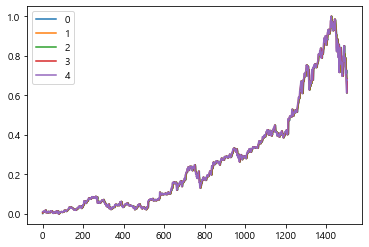

In [80]:
# Checking to see if the scaled data has the same look as the unscaled data
pd.DataFrame(X_train.reshape(1505,5)).plot()

<AxesSubplot:>

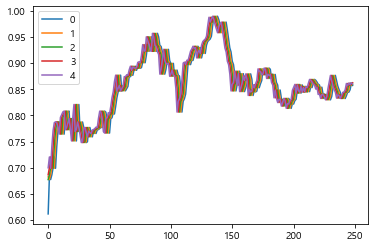

In [77]:
pd.DataFrame(X_test.reshape(249,5)).plot()

In [41]:
# X_train = data
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
X_train_df

,0,1,2,3,4
0,250.87,257.31,258.48,259.15,268.46
1,257.31,258.48,259.15,268.46,266.38
2,258.48,259.15,268.46,266.38,266.35
3,259.15,268.46,266.38,266.35,265.34
4,268.46,266.38,266.35,265.34,267.94
...,...,...,...,...,...
1500,1591.91,1520.91,1551.48,1495.08,1460.83
1501,1520.91,1551.48,1495.08,1460.83,1377.45
1502,1551.48,1495.08,1460.83,1377.45,1343.96
1503,1495.08,1460.83,1377.45,1343.96,1470.90


In [14]:
# y_train = answer
y_train_df = pd.DataFrame(y_train)
y_train_df

,0,1
0,266.38,266.35
1,266.35,265.34
2,265.34,267.94
3,267.94,272.73
4,272.73,271.90
...,...,...
1500,1377.45,1343.96
1501,1343.96,1470.90
1502,1470.90,1461.64
1503,1461.64,1478.02


In [16]:
X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
X_test_df

,0,1,2,3,4
0,1343.96,1470.90,1461.64,1478.02,1501.97
1,1470.90,1461.64,1478.02,1501.97,1539.13
2,1461.64,1478.02,1501.97,1539.13,1500.28
3,1478.02,1501.97,1539.13,1500.28,1575.39
4,1501.97,1539.13,1500.28,1575.39,1629.51
...,...,...,...,...,...
244,1760.33,1760.94,1769.21,1790.66,1784.03
245,1760.94,1769.21,1790.66,1784.03,1792.28
246,1769.21,1790.66,1784.03,1792.28,1786.50
247,1790.66,1784.03,1792.28,1786.50,1793.00


In [131]:
# Hyperparameter
epoch = 50
batch = 150
verbose = 0

In [132]:
# LSTM Model

def LSTM_model(X_train, y_train, X_test, sc):
    # Modules
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # LSTM Architecture
    model = Sequential()
    model.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape=(X_train.shape[1], 1),
                   activation='tanh'))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dense(units=2))
    
    # Compile
    model.compile(optimizer=SGD(lr=0.01, decay=1e-7,
                                momentum=0.9, nesterov=False),
                                loss='mean_squared_error')
    
    # Fitting
    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=verbose)
    
    # Prediction
    prediction = model.predict(X_test)
    
    # Unscale the Prediction to see the actual value
    prediction = sc.inverse_transform(prediction)
    
    return model, prediction
    

In [133]:
# Activation
LSTM, prediction = LSTM_model(X_train, y_train, X_test, sc)

In [82]:
prediction

array([[1456.9852, 1452.2455],
       [1495.761 , 1490.3258],
       [1504.2821, 1498.9469],
       [1522.5005, 1517.112 ],
       [1546.5073, 1541.2845],
       [1573.1979, 1568.2568],
       [1596.3915, 1591.7662],
       [1630.4617, 1625.239 ],
       [1646.7533, 1641.053 ],
       [1647.8289, 1641.7969],
       [1646.8701, 1640.8513],
       [1648.333 , 1642.606 ],
       [1653.4897, 1648.1022],
       [1664.2081, 1658.9281],
       [1674.5632, 1668.7451],
       [1669.8347, 1663.6736],
       [1662.88  , 1656.59  ],
       [1655.3448, 1649.2902],
       [1644.9226, 1639.287 ],
       [1643.1731, 1637.2103],
       [1644.275 , 1638.1337],
       [1649.287 , 1643.502 ],
       [1645.7692, 1640.4093],
       [1647.8695, 1642.3461],
       [1660.8403, 1654.6234],
       [1655.24  , 1648.9658],
       [1635.6505, 1629.8704],
       [1632.2239, 1626.1088],
       [1624.8739, 1618.4596],
       [1615.2854, 1609.1526],
       [1612.1667, 1606.4951],
       [1614.7407, 1609.2933],
       [

In [134]:
def actual_pred_plot(preds):
    """
    Plotting Actual vs Prediction
    """
    actual_pred = pd.DataFrame(columns = ['Adj Close', 'prediction'])
    actual_pred['Adj Close'] = all_data.loc['2019': ,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

(2484.7532, <AxesSubplot:xlabel='Date'>)

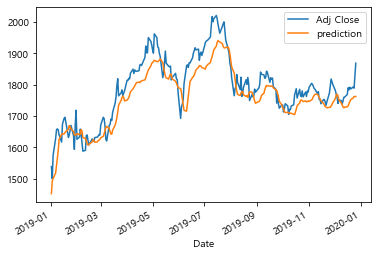

In [135]:
actual_pred_plot(prediction)

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    Result = pd.DataFrame(data = [MAE, RMSE, MSLE, RMSLE, R2],
                          index = ['MAE', 'RMSE', 'MSLE', 'RMSLE', 'R2'],
                          columns = ['Results'])
    
    return Result

In [137]:
y_pred = pd.DataFrame(prediction[:,0])
y_test = all_data.loc['2019': ,'Adj Close'][0:len(prediction)]
y_test.reset_index(drop=True, inplace=True)

In [138]:
print("Epoch = 50, Batch_size = 150")
confirm_result(y_test, y_pred)

Epoch = 50, Batch_size = 150


,Results
MAE,40.503443
RMSE,49.847300
MSLE,0.000772
RMSLE,0.027780
R2,0.758598


In [128]:
# Changing Hyperparameter
epoch = 150

In [129]:
# LSTM Model

def LSTM_model(X_train, y_train, X_test, sc):
    # Modules
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # LSTM Architecture
    model = Sequential()
    model.add(LSTM(units=50,
                   return_sequences=True,
                   input_shape=(X_train.shape[1], 1),
                   activation='tanh'))
    model.add(LSTM(units=50, activation='tanh'))
    model.add(Dense(units=2))
    
    # Compile
    model.compile(optimizer=SGD(lr=0.01, decay=1e-7,
                                momentum=0.9, nesterov=False),
                                loss='mean_squared_error')
    
    # Fitting
    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=verbose)
    
    # Prediction
    prediction = model.predict(X_test)
    
    # Unscale the Prediction to see the actual value
    prediction = sc.inverse_transform(prediction)
    
    return model, prediction
    

In [130]:
LSTM, prediction = LSTM_model(X_train, y_train, X_test, sc)

In [95]:
prediction

array([[1456.575 , 1456.7847],
       [1495.347 , 1495.7958],
       [1504.1683, 1504.6503],
       [1521.9918, 1522.773 ],
       [1545.4952, 1546.7457],
       [1571.923 , 1573.6407],
       [1595.2068, 1597.2573],
       [1629.7014, 1631.8857],
       [1646.3833, 1648.5295],
       [1647.7906, 1649.7644],
       [1646.3314, 1648.4424],
       [1647.4943, 1649.7943],
       [1652.5098, 1655.0059],
       [1663.2958, 1665.9349],
       [1674.4489, 1676.8433],
       [1669.848 , 1672.0481],
       [1662.6809, 1664.8232],
       [1654.7935, 1657.0093],
       [1644.4977, 1646.6561],
       [1643.3127, 1645.193 ],
       [1643.8527, 1645.8618],
       [1648.1354, 1650.5237],
       [1645.25  , 1647.5239],
       [1647.6566, 1649.8118],
       [1660.6132, 1662.7556],
       [1654.9988, 1657.0648],
       [1635.4742, 1637.4032],
       [1632.4124, 1634.1008],
       [1625.0752, 1626.5898],
       [1614.886 , 1616.535 ],
       [1611.4998, 1613.3147],
       [1614.2246, 1616.0847],
       [

(2004.5807, <AxesSubplot:xlabel='Date'>)

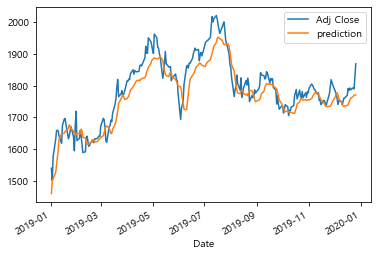

In [120]:
# epoch = 100, batch_size = 150
actual_pred_plot(prediction)

In [121]:
y_pred = pd.DataFrame(prediction[:,0])
y_test = all_data.loc['2019': ,'Adj Close'][0:len(prediction)]
y_test.reset_index(drop=True, inplace=True)

In [124]:
print("Epoch = 100, Batch_size = 150")
confirm_result(y_test, y_pred)

Epoch = 100, Batch_size = 150


,Results
MAE,35.889878
RMSE,44.772541
MSLE,0.000625
RMSLE,0.024990
R2,0.805248


### Overall: Larger epoch turned out to return better results.
<img src="epoch50.png"><img src="epoch100.png"> 
### Couldn't get the exact values, but the flow of price was similar enough.

## Possible Improvements of this Project for the future
- Try using gridsearch to find the best parameter when tuning
- Actually predicting the date of the lowest stock price in the future